### Clustering using Source Time Function


In [1]:
import os
import pandas as pd
import cv2
import numpy as np

# Define the main directory
main_dir = r"C:\Users\ASUS\OneDrive\Desktop\SDA\week2\sourcefunction_archive_all\ALL_MOY_and_OPTI_2025_MAJ_till_31122023"

# Define column names for the DataFrame
columns = [
    "Time","Duration", "Lat", "Lon",
    "Depth(km)", "M0(N.m)", "Mw", "strike1(°)", "dip1(°)", "rake1(°)",
    "strike2(°)", "dip2(°)", "rake2(°)", "img"
]
df = pd.DataFrame(columns=columns)

# Iterate through each earthquake folder
for folder in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder)
    
    if os.path.isdir(folder_path):        
        img_path = os.path.join(folder_path, "cmt.png")  # Assuming image format is PNG
        
        # Check if image exists
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read image with alpha channel (RGBA)
            if img is not None and img.shape[-1] == 4:  # Ensure it's RGBA
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)  # Convert to proper RGBA format
            else:
                img = None  # If not RGBA, discard
        else:
            img = None  # No image found
        
        for file in os.listdir(folder_path):
            if file.startswith("fctmoysource_"):
                file_path = os.path.join(folder_path, file)

                # Read the file
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    
                    # Extract data from the first two lines
                    header_1 = lines[0].strip().split()
                    header_2 = lines[1].strip().split()
                    Total_time = lines[-1].strip().split()[0]
                    # Format time
                    date_part = "-".join(header_1[:3])  # YYYY-MM-DD
                    time_part = ":".join(header_1[3:6])  # HH:MM:SS
                    formatted_time = date_part + " " + time_part  # YYYY-MM-DD HH:MM:SS
                    
                    # Extract values
                    row_data = [
                        formatted_time,float(Total_time), float(header_1[6]), float(header_1[7]),  # Time, Lat, Lon
                        float(header_2[0]), float(header_2[1]), float(header_2[2]),  # Depth, M0, Mw
                        float(header_2[3]), float(header_2[4]), float(header_2[5]),  # Strike1, Dip1, Rake1
                        float(header_2[6]), float(header_2[7]), float(header_2[8]),  # Strike2, Dip2, Rake2
                        img  # Store the image as a NumPy array
                    ]
                    
                    # Append to DataFrame
                    df.loc[len(df)] = row_data


In [2]:
df.head()

,Time,Duration,Lat,Lon,Depth(km),M0(N.m),Mw,strike1(°),dip1(°),rake1(°),strike2(°),dip2(°),rake2(°),img
0,1992-01-20 13:37:03.0,6.046875,27.98,139.40,522.0,8.882000e+18,6.566,47.0,39.0,-155.0,298.0,75.0,-53.0,"[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
1,1992-02-13 01:29:13.0,15.890625,-15.89,166.32,20.0,1.493000e+19,6.716,313.0,40.0,77.0,149.0,51.0,100.0,"[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
2,1992-03-05 14:39:10.0,9.492188,52.90,159.62,53.0,3.607000e+18,6.305,220.0,32.0,91.0,39.0,58.0,90.0,"[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
3,1992-03-07 01:53:37.0,9.562500,10.21,-84.32,79.0,6.732000e+18,6.485,166.0,30.0,16.0,61.0,82.0,119.0,"[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
4,1992-03-13 16:01:04.0,9.632812,52.45,-178.95,214.0,5.273000e+18,6.415,201.0,19.0,-21.0,311.0,83.0,-108.0,"[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."


In [3]:
csv_filename = "Clustering_data_Cleaned.csv"

# Check if the file exists and delete it
if os.path.exists(csv_filename):
    os.remove(csv_filename)

# Save the DataFrame to CSV
df.to_csv(csv_filename, index=False)

In [4]:
pkl_filename = "Clustering_data_with_images.pkl"
df.to_pickle(pkl_filename)

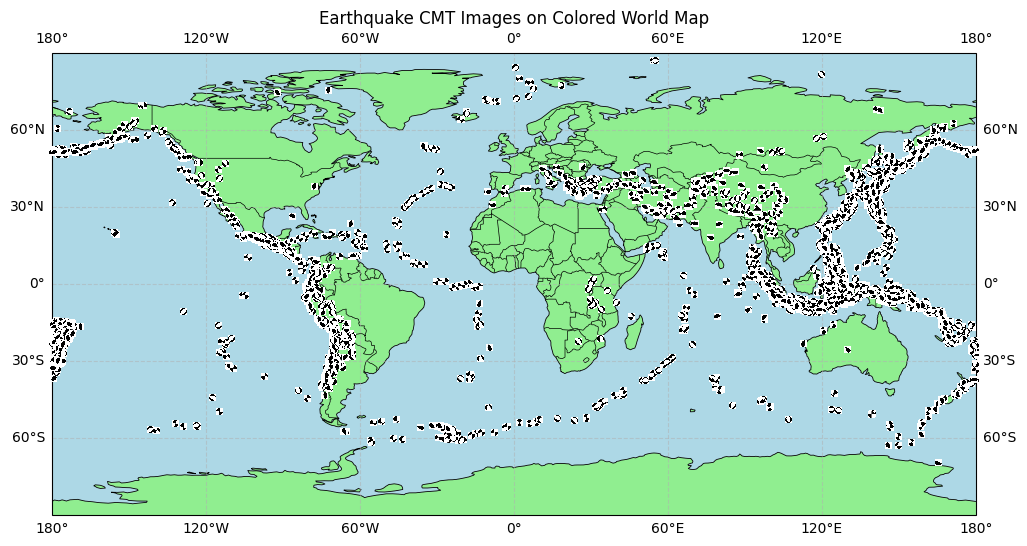

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load DataFrame containing lat, lon, and img columns
df = pd.read_pickle("Clustering_data_with_images.pkl")

# Create the world map with a colored basemap
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Set global extent
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add colored map features
ax.add_feature(cfeature.LAND, facecolor="lightgreen")  # Green land
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Blue ocean
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.6)  # Coastlines
ax.add_feature(cfeature.BORDERS, linestyle="-", edgecolor="black", linewidth=0.5)  # Country borders
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot each image at its respective latitude & longitude
for _, row in df.iterrows():
    lat, lon, img = row["Lat"], row["Lon"], row["img"]

    if img is not None:
        img_rgb = img[:, :, :3]  # Extract RGB channels
        img_resized = np.clip(img_rgb / 255.0, 0, 1)  # Normalize
        
        # Resize & overlay images
        img_box = OffsetImage(img_resized, zoom=0.03)  # Adjust zoom for image size
        ab = AnnotationBbox(
            img_box,
            (lon, lat),  # Centered at (lon, lat)
            frameon=False,
            xycoords="data",
            boxcoords="data",
            box_alignment=(0.5, 0.5),  # Ensure center alignment
            pad=0
        )
        
        ax.add_artist(ab)  # Overlay the image

# Show the final world map with CMT images
plt.title("Earthquake CMT Images on Colored World Map")
plt.show()


In [21]:
df.shape

(4255, 14)

In [22]:
df.columns

Index(['Time', 'Duration', 'Lat', 'Lon', 'Depth(km)', 'M0(N.m)', 'Mw',
       'strike1(°)', 'dip1(°)', 'rake1(°)', 'strike2(°)', 'dip2(°)',
       'rake2(°)', 'img'],
      dtype='object')

In [23]:
def classify_faulting_mechanism(rake):
    if -180 < rake <= -150 or -30 < rake < 30 or 150 < rake <= 180:
        return "Strike slip"
    elif -150 <= rake <= -30:
        return "Normal and normal oblique"
    elif 30 <= rake <= 150:
        return "Reverse and reverse oblique"
    else:
        return "Unknown"  # Handle edge cases

# Apply classification to create a new column
df["Faulting mechanism"] = df["rake1(°)"].apply(classify_faulting_mechanism)


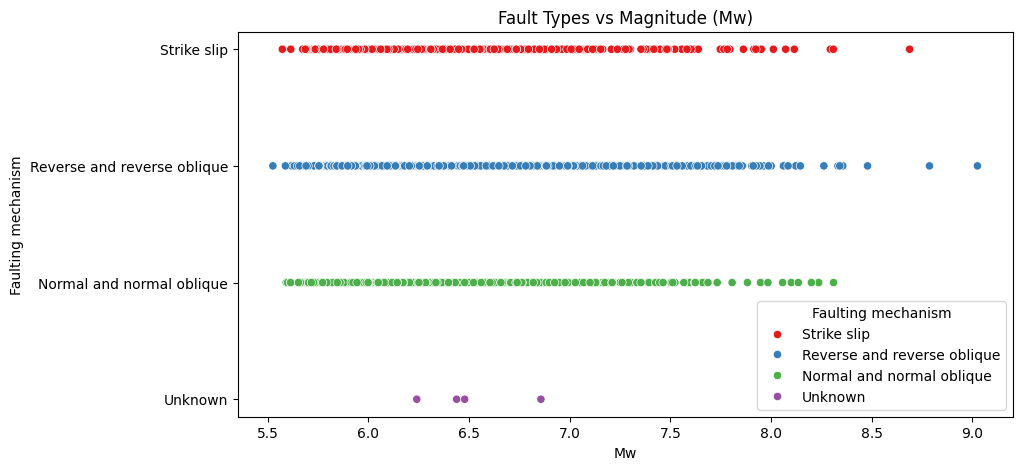

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="Mw", y="Faulting mechanism", hue="Faulting mechanism", palette="Set1", legend=True)
plt.title("Fault Types vs Magnitude (Mw)")
plt.show()

### Clustering using Gaussian Mixture method

In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Function to apply K-Means clustering
def apply_kmeans_clustering(df, features, label_col):
    df_numeric = df[features].select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)
    
    label_encoder = LabelEncoder()
    df["Fault Type Encoded"] = label_encoder.fit_transform(df[label_col])
    num_clusters = len(np.unique(df["Fault Type Encoded"]))
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    cluster_to_label = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        true_labels = df["Fault Type Encoded"].values[cluster_indices]
        if len(true_labels) > 0:
            most_common_label = np.bincount(true_labels).argmax()
            cluster_to_label[cluster] = most_common_label
        else:
            cluster_to_label[cluster] = -1
    
    y_pred = np.array([cluster_to_label.get(c, -1) for c in clusters])
    valid_indices = y_pred != -1
    df.loc[valid_indices, "Classified_KMeans"] = label_encoder.inverse_transform(y_pred[valid_indices])
    df.loc[~valid_indices, "Classified_KMeans"] = "Unknown"
    
    if np.any(valid_indices):
        accuracy = accuracy_score(df.loc[valid_indices, "Fault Type Encoded"], y_pred[valid_indices])
        if "Lat" in features:
            print(f"KMeans Clustering Accuracy with epicentre: {accuracy * 100:.2f}%")
        else:
            print(f"KMeans Clustering Accuracy without epicentre: {accuracy * 100:.2f}%")
    else:
        print("No valid predictions for accuracy calculation.")



In [29]:
# Function to apply Gaussian Mixture Model (GMM) clustering
def apply_gmm_clustering(df, features, label_col):
    df_numeric = df[features].select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)
    
    label_encoder = LabelEncoder()
    df["Fault Type Encoded"] = label_encoder.fit_transform(df[label_col])
    num_clusters = len(np.unique(df["Fault Type Encoded"]))
    
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    clusters = gmm.fit_predict(X_scaled)
    
    cluster_to_label = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        true_labels = df["Fault Type Encoded"].values[cluster_indices]
        if len(true_labels) > 0:
            most_common_label = np.bincount(true_labels).argmax()
            cluster_to_label[cluster] = most_common_label
        else:
            cluster_to_label[cluster] = -1
    
    y_pred = np.array([cluster_to_label.get(c, -1) for c in clusters])
    valid_indices = y_pred != -1
    df.loc[valid_indices, "Classified_GMM"] = label_encoder.inverse_transform(y_pred[valid_indices])
    df.loc[~valid_indices, "Classified_GMM"] = "Unknown"
    
    if np.any(valid_indices):
        accuracy = accuracy_score(df.loc[valid_indices, "Fault Type Encoded"], y_pred[valid_indices])
        if "Lat" in features:
            print(f"GMM Clustering Accuracy with epicentre: {accuracy * 100:.2f}%")
        else:
            print(f"GMM Clustering Accuracy without epicentre: {accuracy * 100:.2f}%")
    else:
        print("No valid predictions for accuracy calculation.")



In [30]:
# Function to apply DBSCAN clustering
def apply_dbscan_clustering(df, features, label_col, eps=0.5, min_samples=5):
    df_numeric = df[features].select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)
    
    label_encoder = LabelEncoder()
    df["Fault Type Encoded"] = label_encoder.fit_transform(df[label_col])
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    
    df["DBSCAN Cluster"] = clusters
    df["Classified_DBSCAN"] = "Unknown"
    
    unique_clusters = np.unique(clusters)
    cluster_to_label = {}
    for cluster in unique_clusters:
        if cluster == -1:
            continue
        cluster_indices = np.where(clusters == cluster)[0]
        true_labels = df["Fault Type Encoded"].values[cluster_indices]
        if len(true_labels) > 0:
            most_common_label = np.bincount(true_labels).argmax()
            cluster_to_label[cluster] = most_common_label
    
    y_pred = np.array([cluster_to_label.get(c, -1) for c in clusters])
    valid_indices = y_pred != -1
    df.loc[valid_indices, "Classified_DBSCAN"] = label_encoder.inverse_transform(y_pred[valid_indices])
    
    if np.any(valid_indices):
        accuracy = accuracy_score(df.loc[valid_indices, "Fault Type Encoded"], y_pred[valid_indices])
        if "Lat" in features:
            print(f"DBSCAN Clustering Accuracy with epicentre: {accuracy * 100:.2f}%")
        else:
            print(f"DBSCAN Clustering Accuracy without epicentre: {accuracy * 100:.2f}%")
    else:
        print("No valid predictions for accuracy calculation.")



In [31]:
selected_features = ['Time','Duration', 'Depth(km)', 'M0(N.m)', 'Mw', 'strike1(°)', 'dip1(°)', 'rake1(°)']
label_column = "Faulting mechanism"
features_with_epicenter = ['Duration', 'Depth(km)', 'M0(N.m)', 'Mw', 'strike1(°)', 'dip1(°)', 'rake1(°)', 'Lat', 'Lon']

apply_kmeans_clustering(df, selected_features, label_column)
apply_kmeans_clustering(df, features_with_epicenter, label_column)
apply_gmm_clustering(df, selected_features, label_column)
apply_gmm_clustering(df, features_with_epicenter, label_column)
apply_dbscan_clustering(df, selected_features, label_column, eps=0.7, min_samples=5)
apply_dbscan_clustering(df, features_with_epicenter, label_column, eps=0.7, min_samples=5)


KMeans Clustering Accuracy without epicentre: 68.88%
KMeans Clustering Accuracy with epicentre: 69.52%
GMM Clustering Accuracy without epicentre: 62.44%
GMM Clustering Accuracy with epicentre: 51.87%
DBSCAN Clustering Accuracy without epicentre: 58.08%
DBSCAN Clustering Accuracy with epicentre: 96.00%
